In [1]:
from torchvision import datasets
import torch
data_folder = '~/data/FMNIST' # This can be any directory # you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True,train=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 11885228.13it/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 205625.68it/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1373694.03it/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4282482.55it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



In [2]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

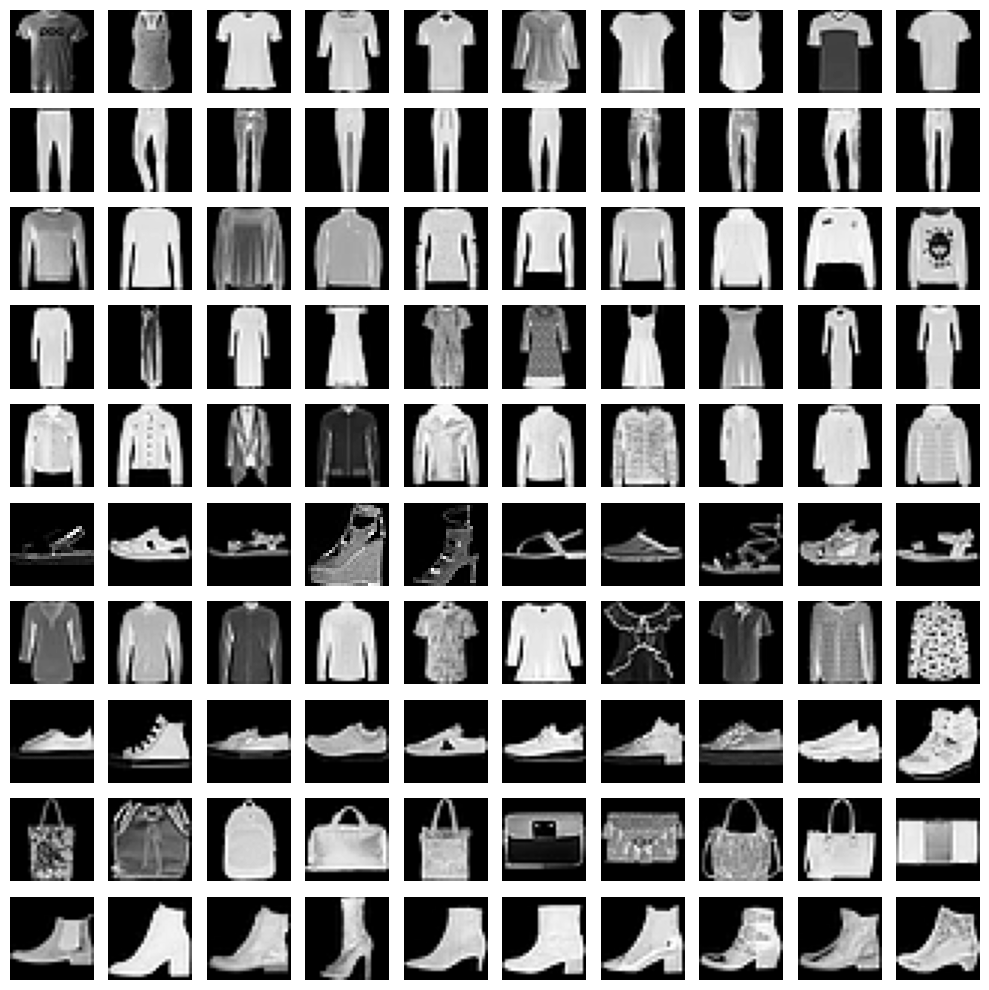

In [4]:
R, C = len(tr_targets.unique()), 10
fig, ax = plt.subplots(R, C, figsize=(10,10))
for label_class, plot_row in enumerate(ax):
  label_x_rows = np.where(tr_targets == label_class)[0]
  for plot_cell in plot_row:
    plot_cell.grid(False); plot_cell.axis('off')
    ix = np.random.choice(label_x_rows)
    x, y = tr_images[ix], tr_targets[ix]
    plot_cell.imshow(x, cmap='gray')
plt.tight_layout()

In [5]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision import datasets

In [6]:
class FMNISTDataset(Dataset):
  def __init__(self,x,y):
    x = x.float()
    # We are flattening each image, h=w=28
    # -1 means other dimennsion would adjust automatically, based on the number elements
    x = x.view(-1,28*28)
    self.x, self.y = x,y
  def __getitem__(self,idx):
    x,y = self.x[idx], self.y[idx]
    return x.to(device), y.to(device)
  def __len__(self):
    return len(self.x)

In [7]:
def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True)
  return trn_dl

In [8]:
from torch.optim import SGD
def get_model():
  model = nn.Sequential(
      nn.Linear(28 * 28, 1000),
      nn.ReLU(),
      nn.Linear(1000, 10)
      ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = SGD(model.parameters(), lr=1e-2)
  return model, loss_fn, optimizer

In [9]:
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  prediction = model(x)
  max_values, argmaxes = prediction.max(-1)
  is_correct = argmaxes == y
  return is_correct.cpu().numpy().tolist()

In [13]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    # Flush gradients memory for next batch of calculations
    optimizer.zero_grad()
    return batch_loss.item()

In [12]:
losses, accuracies = [], []
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4


<ipython-input-14-07f3345cba83>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


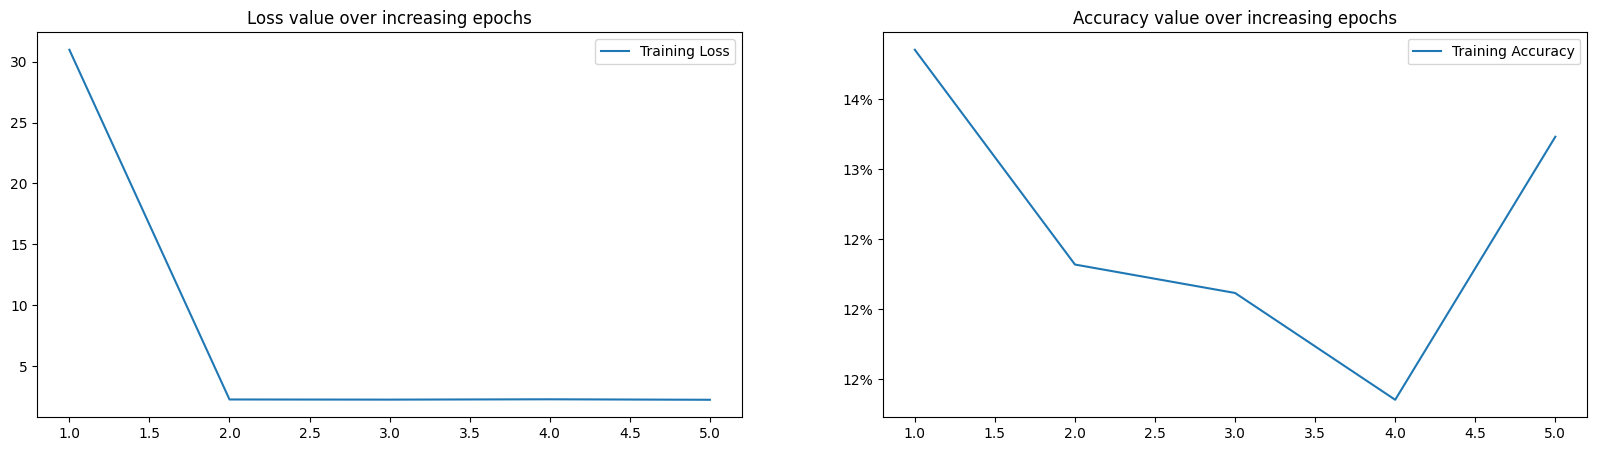

In [14]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()